```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

In this notebook we will load ensemble initial states, and simply 
look at what we have.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Investigating the ensemble initial conditions

In this notebook we will load the ensemble initial conditions, and simply take a look on the data we got.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, CDKLM16

In [2]:
%cuda_context_handler gpu_ctx

## Loading the data


In [3]:
ensemble_init_path = os.path.abspath('presented_data/ensemble_init/')
assert len(os.listdir(ensemble_init_path)) == 100 or len(os.listdir(ensemble_init_path)) == 101, \
    "Ensemble init folder has wrong number of files"

truth_path = os.path.abspath('presented_data/true_state/')
assert len(os.listdir(truth_path)) == 2 or len(os.listdir(truth_path)) == 3, "Truth folder has wrong number of files"

### Define functions for plotting

In [4]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), 
            interior=False, color_bar_from_zero=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_max = np.max(np.abs(eta))
    huv_max  = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    eta_min = -eta_max
    huv_min = -huv_max
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
    

    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max, cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max, cmap=eta_cmap)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max, cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max, cmap=huv_cmap)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max, cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max, cmap=huv_cmap)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
    ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))


# Read initial conditions and mean and variance 

Reading files...

In [5]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

ensemble_init_file_name = os.path.join(ensemble_init_path, "double_jet_case_XX.nc")
num_files = 100
sim_readers = [None]*num_files
for i in range(num_files):
    sim_readers[i] = SimReader.SimNetCDFReader(ensemble_init_file_name.replace('XX', str(i).zfill(2)))

Get mean...

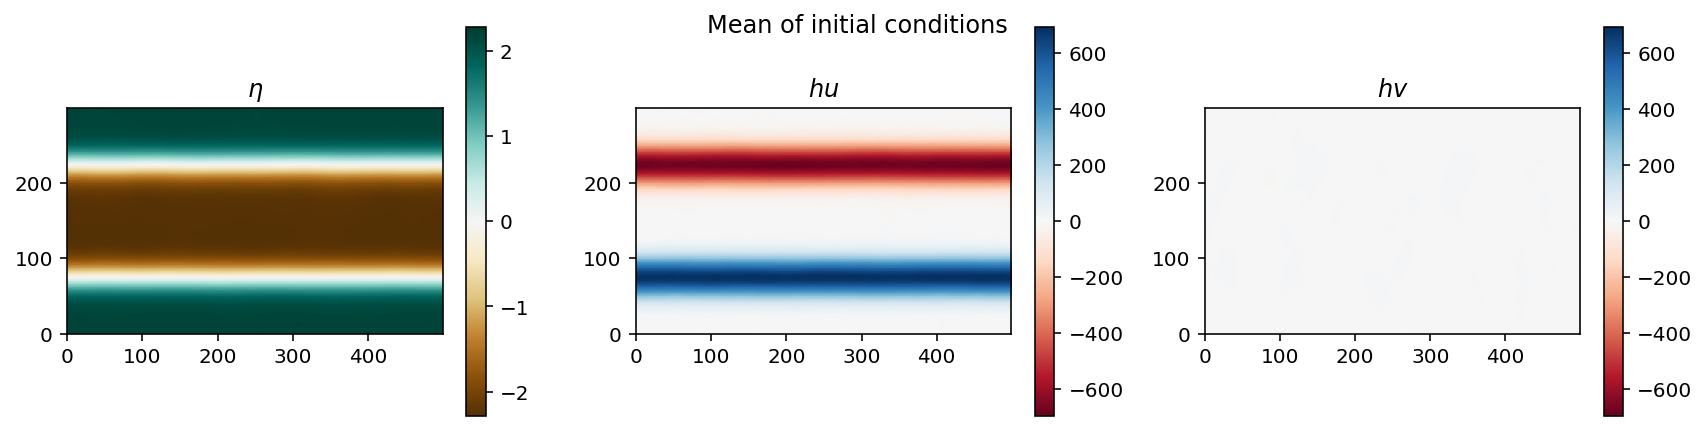

In [6]:
mean_eta, mean_hu, mean_hv, tmp_t = sim_readers[0].getLastTimeStep()
for i in range(1,num_files):
    tmp_eta, tmp_hu, tmp_hv, tmp_t = sim_readers[i].getLastTimeStep()
    mean_eta += tmp_eta
    mean_hu += tmp_hu
    mean_hv += tmp_hv
mean_eta /= num_files
mean_hu  /= num_files
mean_hv  /= num_files
imshow3(mean_eta, mean_hu, mean_hv, title='Mean of initial conditions')

Get variance

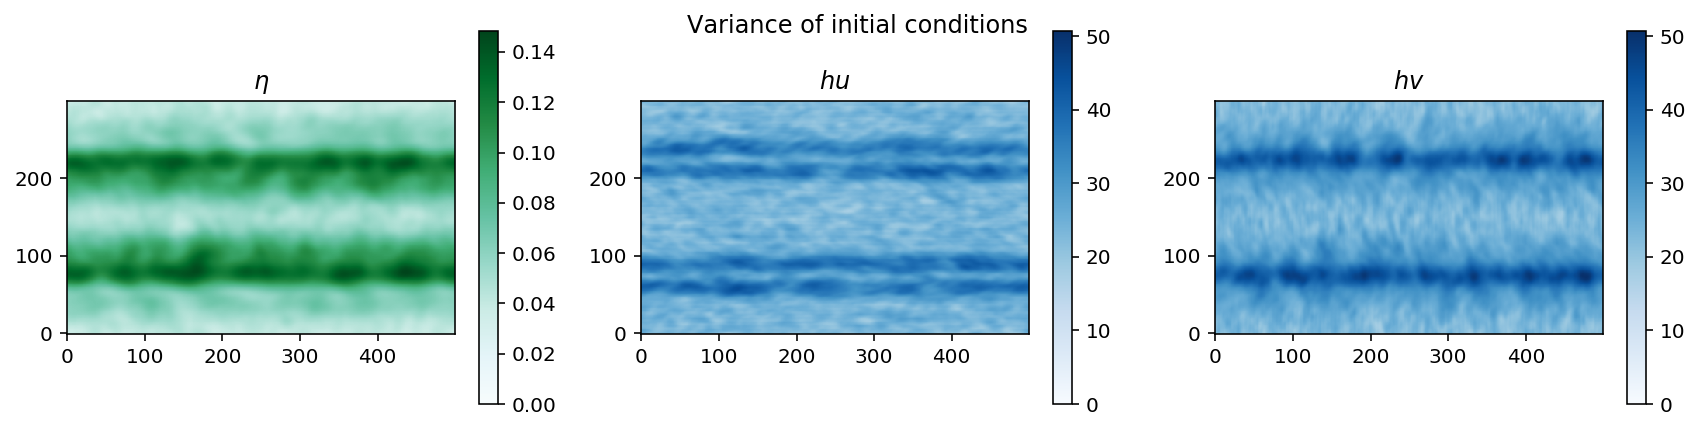

In [7]:
var_eta, var_hu, var_hv = np.zeros_like(mean_eta), np.zeros_like(mean_hu), np.zeros_like(mean_hv)
for sim_reader in sim_readers:
    tmp_eta, tmp_hu, tmp_hv, tmp_t = sim_reader.getLastTimeStep()
    var_eta += (tmp_eta - mean_eta)**2
    var_hu  += (tmp_hu  - mean_hu )**2
    var_hv  += (tmp_hv  - mean_hv )**2
var_eta = np.sqrt(var_eta/(num_files-1))
var_hu  = np.sqrt(var_hu /(num_files-1))
var_hv  = np.sqrt(var_hv /(num_files-1))

imshow3(var_eta, var_hu, var_hv, color_bar_from_zero=True, title='Variance of initial conditions')

## Testing how many simulators we can make before we run out of memory

In [8]:
print(gpu_ctx.cuda_device.total_memory()/(1000*1000))

3153.985536


In [9]:
%%time
ensemble_particles = [None]*num_files
for i in range(num_files):
    print(i)
    ensemble_particles[i] = CDKLM16.CDKLM16.fromfilename(gpu_ctx, 
                                                         ensemble_init_file_name.replace('XX', str(i).zfill(2)),
                                                         cont_write_netcdf=False)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 2.85 s, sys: 5.48 s, total: 8.34 s
Wall time: 14.1 s


In [10]:
%%time
current_t = ensemble_particles[i].t
next_t = current_t + 24*60*60
for i in range(num_files):
    print(i)
    ensemble_particles[i].dataAssimilationStep(next_t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 6min 23s, sys: 58.3 s, total: 7min 22s
Wall time: 7min 21s


# Look at var and mean again

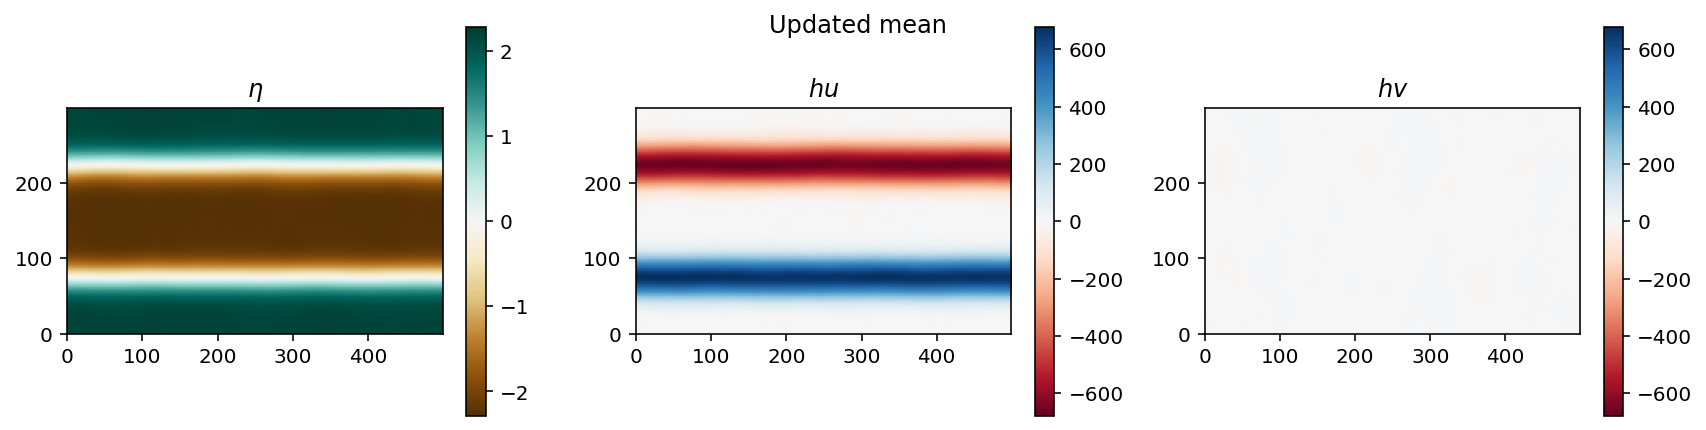

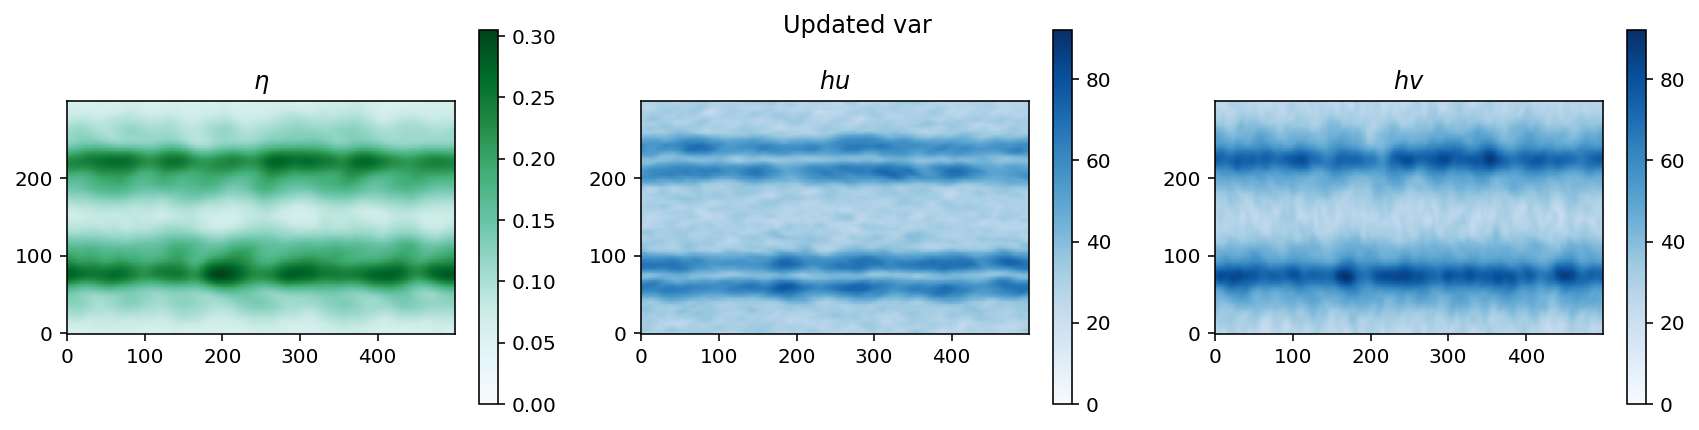

In [11]:
def ensemble_mean_var(sims):
    mean_eta, mean_hu, mean_hv = sims[0].download(interior_domain_only=True)
    num_sims = len(sims)
    for i in range(1,num_sims):
        tmp_eta, tmp_hu, tmp_hv = sims[i].download(interior_domain_only=True)
        mean_eta += tmp_eta
        mean_hu += tmp_hu
        mean_hv += tmp_hv
    mean_eta /= num_sims
    mean_hu  /= num_sims
    mean_hv  /= num_sims

    var_eta, var_hu, var_hv = np.zeros_like(mean_eta), np.zeros_like(mean_hu), np.zeros_like(mean_hv)
    for sim in sims:
        tmp_eta, tmp_hu, tmp_hv = sim.download(interior_domain_only=True)
        var_eta += (tmp_eta - mean_eta)**2
        var_hu  += (tmp_hu  - mean_hu )**2
        var_hv  += (tmp_hv  - mean_hv )**2
    var_eta = np.sqrt(var_eta/(num_sims-1))
    var_hu  = np.sqrt(var_hu /(num_sims-1))
    var_hv  = np.sqrt(var_hv /(num_sims-1))
    return mean_eta, mean_hu, mean_hv, var_eta, var_hu, var_hv
    
mean_eta1, mean_hu1, mean_hv1, var_eta1, var_hu1, var_hv1 = ensemble_mean_var(ensemble_particles)
imshow3(mean_eta1, mean_hu1, mean_hv1, title='Updated mean')
imshow3(var_eta1, var_hu1, var_hv1, title='Updated var', color_bar_from_zero=True)

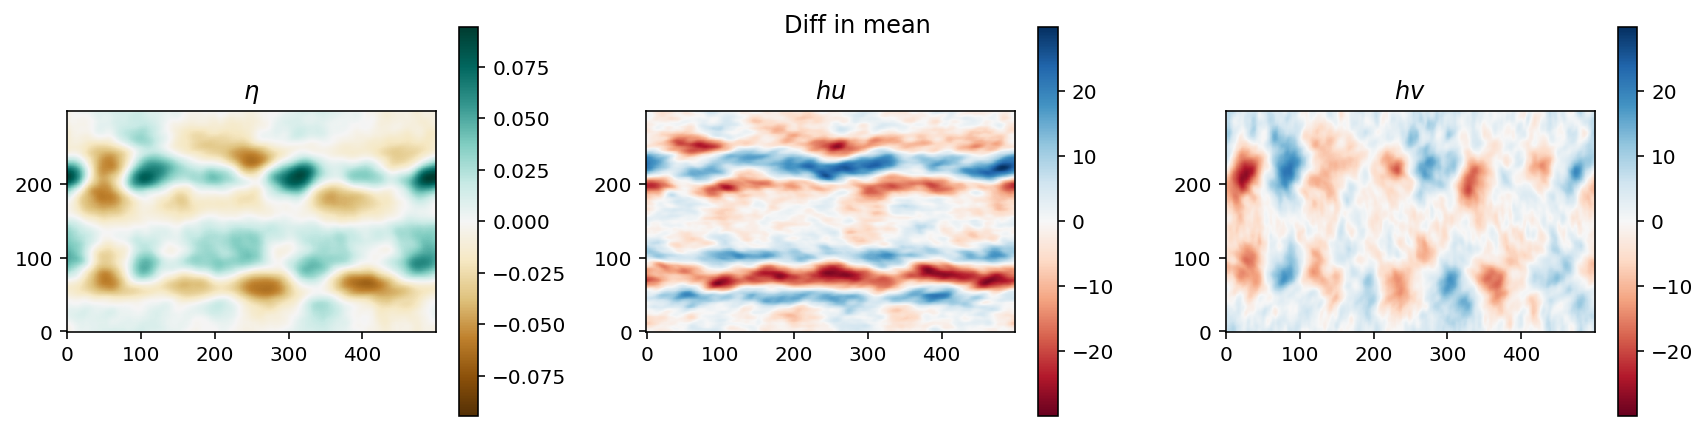

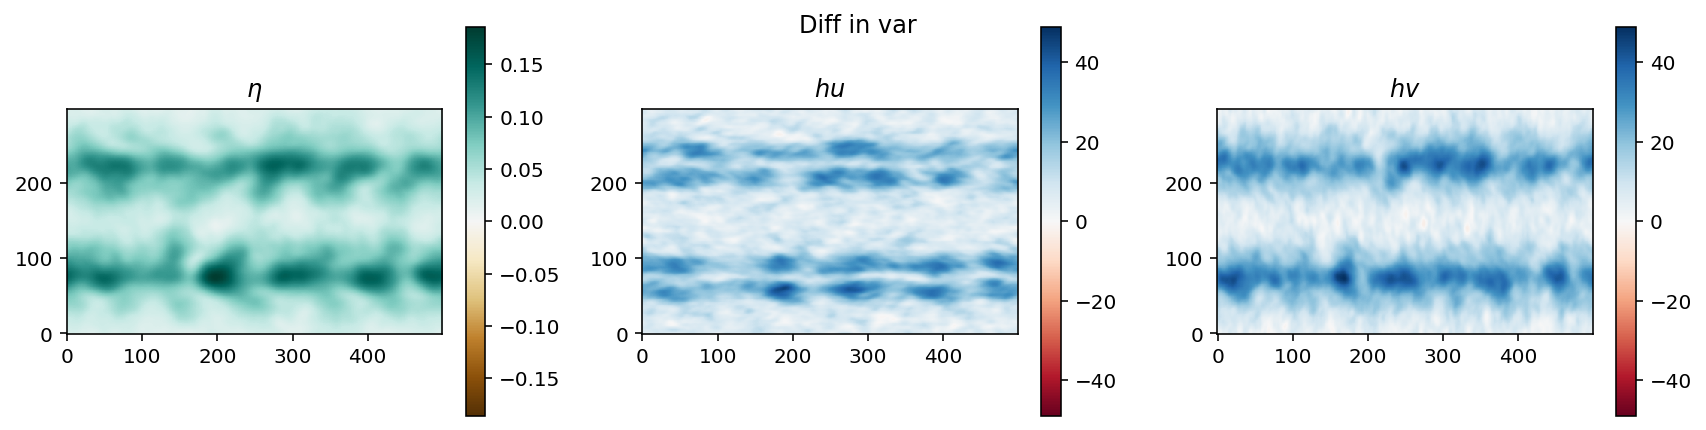

In [12]:
imshow3(mean_eta1-mean_eta, mean_hu1-mean_hu, mean_hv1-mean_hv, title='Diff in mean')
imshow3(var_eta1-var_eta, var_hu1-var_hu, var_hv1-var_hv, title='Diff in var', color_bar_from_zero=False)

In [13]:
%%time
for i in range(num_files):
    print(i)
    ensemble_particles[i].cleanUp()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 6.74 s, sys: 132 ms, total: 6.88 s
Wall time: 6.85 s
